In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd

from utils_data import import_process_law
from utils import discretize
import numpy as np
from divexplorer import DivergenceExplorer
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_colwidth', None)
import time
from divexplorer import DivergencePatternProcessor
from utils import printable


# Import law school dataset

In [3]:
dataset_name = 'law'

df, target_rank = import_process_law(use_rank_score = True)

In [4]:
df = df.rename(columns={ "race": "ethnicity", "sex": "gender"})
df = df.replace({ "ethnicity": { "White": "Caucasian", "Black": "African-American" }})

In [5]:
abbreviations = {'race=White': 'ethnicity=Caucasian', 'race=Black': 'ethnicity=African-American', \
                 'sex':'gender', 'race': 'ethnicity', '=>=': '≥', '=>': '>', '=<=': '≤', '=<': '<'}

# Scoring

In [6]:
scaler = MinMaxScaler()
attributes = ['ethnicity', 'gender']
cols = ['LSAT', 'UGPA']
df_scoring = df[attributes+cols].copy()
df_scoring[cols] = scaler.fit_transform(df_scoring[cols])
df_scoring['score'] = (df_scoring[cols[0]] + df_scoring[cols[1]])/2
df_scoring = df_scoring.drop(columns=cols)
target_col = 'score'

## Scoring - Divergence analysis

In [7]:
min_support_count = 100
min_support = np.round(min_support_count/len(df_scoring), 3)
print(f"min_support: {min_support}")

min_support: 0.005


In [8]:
fp_diver = DivergenceExplorer(df_scoring)

try:
    start_time = time.time()
    subgroups = fp_diver.get_pattern_divergence(min_support=min_support, quantitative_outcomes=[target_col])
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.06387186050415039 seconds ---


In [9]:
fp_details = DivergencePatternProcessor(subgroups, target_col)

try:
    
    start_time = time.time()
    patterns = fp_details.get_patterns(th_redundancy=0)
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.0003418922424316406 seconds ---


In [10]:
cols = ['itemset', 'support', target_col, f"{target_col}_div", f"{target_col}_t"]

idx_top = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[False, False]).head(3).index.tolist()
idx_bot = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[True, False]).head(3).index.tolist()

subgroups_print = printable(patterns[cols].loc[idx_top+idx_bot], target_col, abbreviations=abbreviations, round_v = 3)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))


,itemset,support,score,score_div,score_t
5,"ethnicity=Caucasian, gender=Female",0.354,0.752,0.020,16.8
1,ethnicity=Caucasian,0.839,0.747,0.014,15.2
3,"ethnicity=Caucasian, gender=Male",0.486,0.743,0.010,9.2
10,"ethnicity=African-American, gender=Male",0.022,0.592,-0.140,31.1
6,ethnicity=African-American,0.059,0.593,-0.139,50.2
8,"ethnicity=African-American, gender=Female",0.037,0.594,-0.138,40.3


\begin{tabular}{lrrrr}
\toprule
itemset & support & score & score_div & score_t \\
\midrule
ethnicity=Caucasian, gender=Female & 0.354000 & 0.752000 & 0.020000 & 16.800000 \\
ethnicity=Caucasian & 0.839000 & 0.747000 & 0.014000 & 15.200000 \\
ethnicity=Caucasian, gender=Male & 0.486000 & 0.743000 & 0.010000 & 9.200000 \\
ethnicity=African-American, gender=Male & 0.022000 & 0.592000 & -0.140000 & 31.100000 \\
ethnicity=African-American & 0.059000 & 0.593000 & -0.139000 & 50.200000 \\
ethnicity=African-American, gender=Female & 0.037000 & 0.594000 & -0.138000 & 40.300000 \\
\bottomrule
\end{tabular}



In [11]:
patterns.loc[patterns['itemset']==frozenset()].iloc[0][target_col].round(3)

0.732

# Ranking

In [12]:
df.head()

,ethnicity,gender,LSAT,UGPA,score_rank
0,Caucasian,Male,37.5,4.0,1.000000
1,Caucasian,Male,36.0,3.0,0.933033
2,Caucasian,Male,44.0,4.0,0.895958
3,Caucasian,Male,40.0,2.8,0.870551
4,Caucasian,Female,44.0,3.8,0.851340


In [13]:
attributes = df.columns.drop(target_rank)

df_ranking_discretized = discretize(df, attributes=attributes, dataset_name=dataset_name, bins=4)

target_col = target_rank

In [14]:
df_ranking_discretized.head()

,ethnicity,gender,LSAT,UGPA,score_rank
0,Caucasian,Male,(37.0-41.0],>3.5,1.000000
1,Caucasian,Male,(33.0-37.0],<=3.0,0.933033
2,Caucasian,Male,>41.0,>3.5,0.895958
3,Caucasian,Male,(37.0-41.0],<=3.0,0.870551
4,Caucasian,Female,>41.0,>3.5,0.851340


## Ranking - Divergence analysis

In [15]:
min_support_count = 100
min_support = np.round(min_support_count/len(df_scoring), 3)
print(f"min_support: {min_support}")

min_support: 0.005


In [16]:
fp_diver = DivergenceExplorer(df_ranking_discretized)

try:
    start_time = time.time()
    subgroups = fp_diver.get_pattern_divergence(min_support=min_support, quantitative_outcomes=[target_col])
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.09620904922485352 seconds ---


In [17]:
fp_details = DivergencePatternProcessor(subgroups, target_col)

try:
    
    start_time = time.time()
    patterns = fp_details.get_patterns(th_redundancy=0)
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.0005519390106201172 seconds ---


In [18]:
cols = ['itemset', 'support', target_col, f"{target_col}_div", f"{target_col}_t"]

idx_top = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[False, False]).head(3).index.tolist()
idx_bot = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[True, False]).head(3).index.tolist()

subgroups_print = printable(patterns[cols].loc[idx_top+idx_bot], target_col, abbreviations=abbreviations, round_v = 3)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))


,itemset,support,score_rank,score_rank_div,score_rank_t
114,"LSAT>41.0, UGPA>3.5, ethnicity=Caucasian, gender=Female",0.030,0.430,0.021,8.7
61,"LSAT>41.0, UGPA>3.5, ethnicity=Caucasian",0.071,0.429,0.020,13.0
87,"LSAT>41.0, UGPA>3.5, ethnicity=Caucasian, gender=Male",0.041,0.428,0.019,9.9
155,"LSAT≤33.0, ethnicity=African-American, gender=Male",0.016,0.381,-0.028,25.6
169,"LSAT≤33.0, UGPA≤3.0, ethnicity=African-American, gender=Male",0.012,0.381,-0.028,21.0
116,"LSAT≤33.0, UGPA≤3.0, ethnicity=African-American",0.029,0.381,-0.028,31.4


\begin{tabular}{lrrrr}
\toprule
itemset & support & score_rank & score_rank_div & score_rank_t \\
\midrule
LSAT>41.0, UGPA>3.5, ethnicity=Caucasian, gender=Female & 0.030000 & 0.430000 & 0.021000 & 8.700000 \\
LSAT>41.0, UGPA>3.5, ethnicity=Caucasian & 0.071000 & 0.429000 & 0.020000 & 13.000000 \\
LSAT>41.0, UGPA>3.5, ethnicity=Caucasian, gender=Male & 0.041000 & 0.428000 & 0.019000 & 9.900000 \\
LSAT≤33.0, ethnicity=African-American, gender=Male & 0.016000 & 0.381000 & -0.028000 & 25.600000 \\
LSAT≤33.0, UGPA≤3.0, ethnicity=African-American, gender=Male & 0.012000 & 0.381000 & -0.028000 & 21.000000 \\
LSAT≤33.0, UGPA≤3.0, ethnicity=African-American & 0.029000 & 0.381000 & -0.028000 & 31.400000 \\
\bottomrule
\end{tabular}



In [19]:
patterns.loc[patterns['itemset']==frozenset()].iloc[0][target_col].round(3)

0.409

## Redundancy pruning

In [20]:
epsilon = 0.0015

In [21]:
fp_details = DivergencePatternProcessor(subgroups, target_col)

try:
    
    start_time = time.time()
    patterns = fp_details.get_patterns(th_redundancy=epsilon)
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.0005669593811035156 seconds ---


In [22]:
cols = ['itemset', 'support', target_col, f"{target_col}_div", f"{target_col}_t"]

idx_top = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[False, False]).head(3).index.tolist()
idx_bot = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[True, False]).head(3).index.tolist()

subgroups_print = printable(patterns[cols].loc[idx_top+idx_bot], target_col, abbreviations=abbreviations, round_v = 3)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))


,itemset,support,score_rank,score_rank_div,score_rank_t
54,"LSAT>41.0, UGPA>3.5",0.076,0.427,0.018,12.6
66,"LSAT=(37.0-41.0], UGPA>3.5, ethnicity=Caucasian",0.065,0.425,0.015,10.2
18,LSAT>41.0,0.199,0.423,0.013,15.3
81,"LSAT≤33.0, ethnicity=African-American",0.045,0.381,-0.028,37.1
70,ethnicity=African-American,0.059,0.383,-0.026,32.9
191,"LSAT≤33.0, ethnicity=Asian, gender=Female",0.006,0.385,-0.025,16.2


\begin{tabular}{lrrrr}
\toprule
itemset & support & score_rank & score_rank_div & score_rank_t \\
\midrule
LSAT>41.0, UGPA>3.5 & 0.076000 & 0.427000 & 0.018000 & 12.600000 \\
LSAT=(37.0-41.0], UGPA>3.5, ethnicity=Caucasian & 0.065000 & 0.425000 & 0.015000 & 10.200000 \\
LSAT>41.0 & 0.199000 & 0.423000 & 0.013000 & 15.300000 \\
LSAT≤33.0, ethnicity=African-American & 0.045000 & 0.381000 & -0.028000 & 37.100000 \\
ethnicity=African-American & 0.059000 & 0.383000 & -0.026000 & 32.900000 \\
LSAT≤33.0, ethnicity=Asian, gender=Female & 0.006000 & 0.385000 & -0.025000 & 16.200000 \\
\bottomrule
\end{tabular}



In [23]:
patterns = fp_details.get_patterns(th_redundancy=0)
itemset_top, itemset_bot = tuple(patterns.sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[False, False]).iloc[[0,-1]].itemset.values)
itemset_top, itemset_bot

(frozenset({'LSAT=>41.0',
            'UGPA=>3.5',
            'ethnicity=Caucasian',
            'gender=Female'}),
 frozenset({'LSAT=<=33.0', 'ethnicity=African-American', 'gender=Male'}))

## Plot top

In [24]:
shapley_values_top = fp_details.shapley_value(itemset_top)
shapley_values_bot = fp_details.shapley_value(itemset_bot)

shapley_values_top = dict(sorted(shapley_values_top.items(), key=lambda item: item[1], reverse=False))
shapley_values_bot = dict(sorted(shapley_values_bot.items(), key=lambda item: item[1], reverse=False))

from utils import abbreviate_dict
shapley_values_top = abbreviate_dict(shapley_values_top, abbreviations)
shapley_values_bot = abbreviate_dict(shapley_values_bot, abbreviations)

In [25]:
shapley_values_bot

{frozenset({'ethnicity=African-American'}): -0.021127139285684333,
 frozenset({'LSAT≤33.0'}): -0.0074855763098172845,
 frozenset({'gender=Male'}): 0.0003056753825177634}

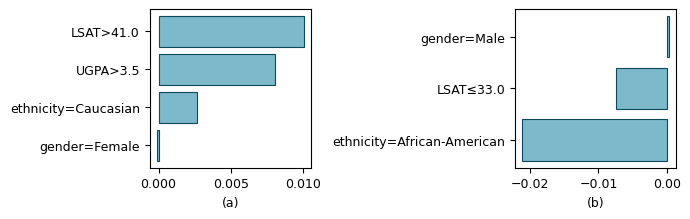

In [26]:
from utils import plot_comparison_ShapleyValues


plot_comparison_ShapleyValues(shapley_values_top, shapley_values_bot,
    size_fig=(7, 2.3),
    shared_items=False,
    save_fig=True,
    name_fig='law_students_ranking_shap_AVGRANK_0.005_gamma_0-1_top_last',
    labelsize=9,
    subcaption=True,
)

## Corrective

In [27]:
correctives = []

dict_len_itemsets = fp_details.dict_len_pattern_divergence
for len_itemset in dict_len_itemsets.keys():
    if len_itemset < 2:
        continue
    for itemset in dict_len_itemsets[len_itemset]:
        itemset_divergence = dict_len_itemsets[len_itemset][itemset]
        for item in itemset:
            subset = itemset - frozenset([item])
            subset_divergence = dict_len_itemsets[len_itemset-1][subset]
            corr_f =  abs(subset_divergence) - abs(itemset_divergence) 
            correctives.append([len_itemset, itemset, item, subset, itemset_divergence, subset_divergence, corr_f])

In [28]:
df_corr = pd.DataFrame(correctives, columns=['len_itemset', 'itemset', 'item', 'subset', 'itemset_divergence', 'subset_divergence', 'corr_f'])
df_corr = df_corr.loc[df_corr['corr_f'] > 0]

In [29]:
cols = ['item', 'subset', 'subset_divergence', 'itemset_divergence', 'corr_f']
subgroups_print = df_corr[cols].sort_values('corr_f', ascending=False).head(5)
from utils import sort_itemset

subgroups_print["item"] = subgroups_print["item"].apply(
    lambda x: sort_itemset(frozenset([x]), abbreviations=abbreviations)
)

subgroups_print["subset"] = subgroups_print["subset"].apply(
    lambda x: sort_itemset(x, abbreviations=abbreviations)
)
subgroups_print["subset_divergence"] = subgroups_print["subset_divergence"].apply(lambda x: round(x, 3))
subgroups_print["itemset_divergence"] = subgroups_print["itemset_divergence"].apply(lambda x: round(x, 3))
subgroups_print["corr_f"] = subgroups_print["corr_f"].apply(lambda x: round(x, 3))

subgroups_print

,item,subset,subset_divergence,itemset_divergence,corr_f
500,LSAT≤33.0,"UGPA>3.5, ethnicity=Caucasian, gender=Female",0.014,0.000,0.013
276,LSAT≤33.0,"UGPA>3.5, ethnicity=Caucasian",0.013,0.001,0.012
314,UGPA>3.5,"LSAT≤33.0, gender=Female",-0.015,-0.004,0.010
524,LSAT≤33.0,"UGPA>3.5, ethnicity=Caucasian, gender=Male",0.013,0.003,0.010
126,LSAT>41.0,ethnicity=Asian,-0.016,-0.006,0.010


In [30]:
item, subset = tuple(df_corr[cols].sort_values('corr_f', ascending=False).iloc[0][['item', 'subset']].values)
itemset = frozenset([item]).union(subset)

In [31]:
fp_details.shapley_value(itemset)

{frozenset({'gender=Female'}): -0.0008398891573453046,
 frozenset({'UGPA=>3.5'}): 0.00960234128624754,
 frozenset({'ethnicity=Caucasian'}): 0.004531757795685848,
 frozenset({'LSAT=<=33.0'}): -0.012949997836223979}

In [ ]:
item_score = fp_details.dict_len_pattern_divergence

from utils_lattice import plot_lattice_itemset

fig = plot_lattice_itemset(
    itemset,
    item_score, get_lower=True, th_divergence=None, displayItemsetLabels=True, plot_bgcolor="#FFFFFF", font_size_div=10,
                font_size_ItemsetLabels=10)





In [ ]:

fig.write_image(f'lattice_corrective_law_students_ranking_AVGRANK_{min_support}.pdf',width=660, height=330)